# Inversion of amplitude of anomalous magnetic field data produced by a synthetic kimberlitic model varying the magnetization direction

This notebook runs inversion of amplitude of anomalous magnetic field data using Levenberg-Marquadt's algorithm. The data was generated from a kimberlitic model using the poligonal prisms function from fatiando.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

from fatiando import utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.vis import mpl, myv
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
from matplotlib.mlab import normpdf

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


### Auxiliary functions

In [2]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing model parameters

In [3]:
with open('../synthetic_data/kimberlite/kimberlite_model.pickle') as w:
        kimberlite_model = pickle.load(w)

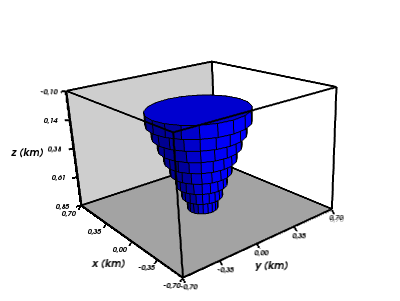

In [4]:
img(filename='../synthetic_data/kimberlite/kimberlite_true.png')

### Observation points and observed data

In [5]:
with open('../synthetic_data/grids/regular_grid_50x50_2km2.pickle') as w:
        regular_grid = pickle.load(w)

In [6]:
with open('../synthetic_data/kimberlite/kimberlite_data.pickle') as w:
        kimberlite_data = pickle.load(w)

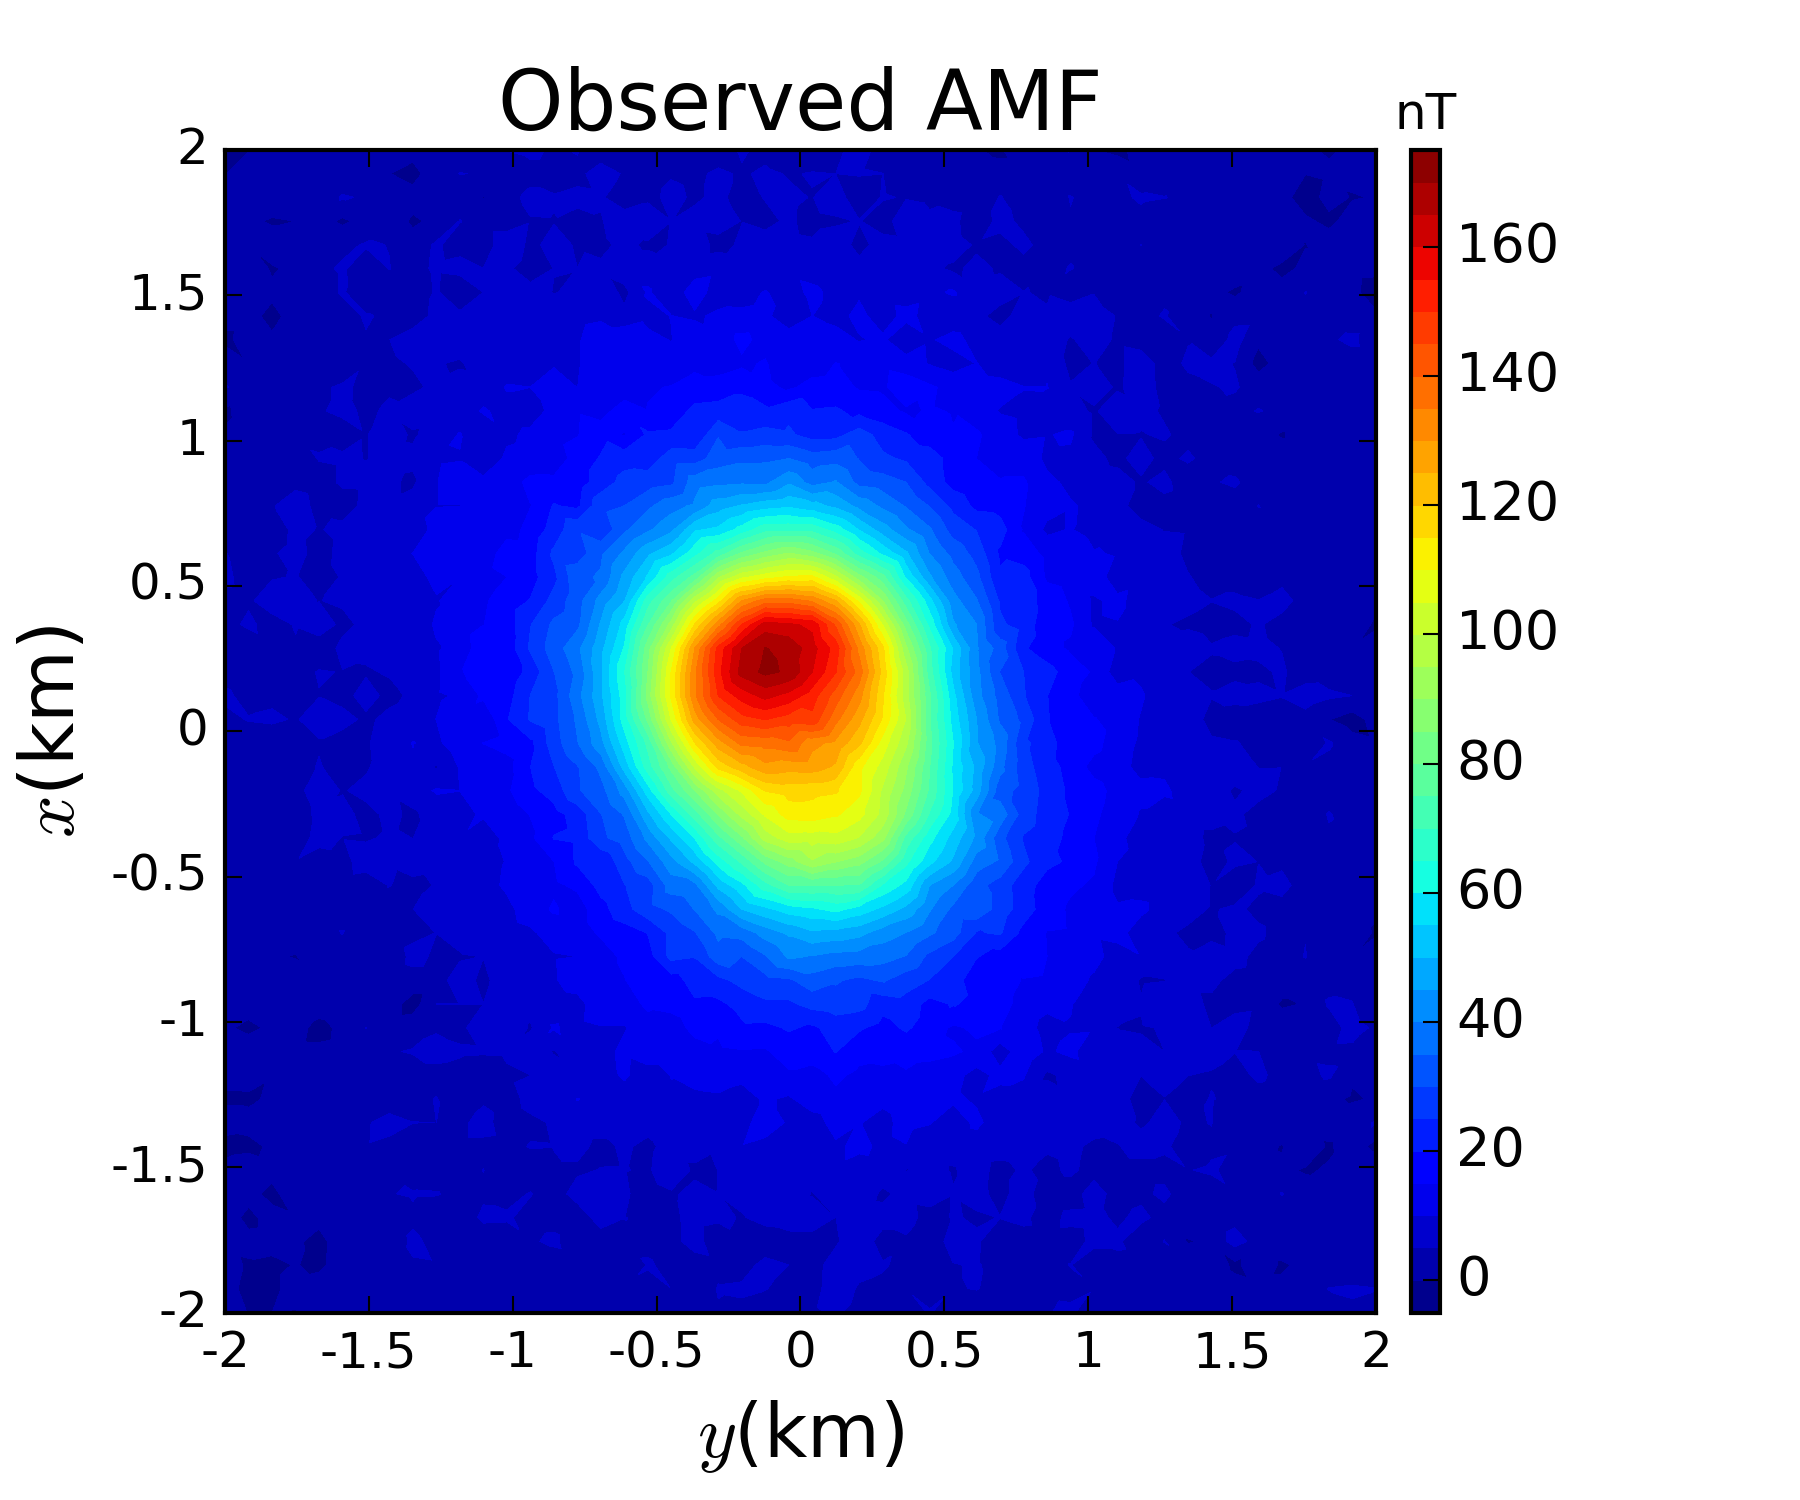

In [7]:
img(filename='../synthetic_data/kimberlite/obs_amf.png', width=400, height=400)

### Parameters for inversion

In [9]:
M = 10 # number of vertices per prism
L = 8 # number of prisms
P = L*(M+2) + 1 # number of parameters

# limits for parameters in meters
rmin = 10.
rmax = 1300.
x0min = -1300.
x0max = 1300.
y0min = -1300.
y0max = 1300.
dzmin = 10.
dzmax = 300.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

itmax = 30
itmax_marq = 10
epsilon = 1.0e-5     # stop criterion

deltax = 0.01*np.max(x0max)
deltay = 0.01*np.max(y0max)
deltar = 0.01*np.max(rmax)# increment of derivatives
deltaz = 0.01*np.max(dzmax)
m_out = np.zeros(M + 2)  # outcropping body parameters
#m_out = kimberlite_model['param_vec'][:M+2]

inc = kimberlite_model['inc']
dec = kimberlite_model['dec']
z0 = kimberlite_model['z0']
dz = 200.
props = {'magnetization': utils.ang2vec(
        kimberlite_model['intensity'], inc, dec)}
dobs = kimberlite_data['amf_obs']
xp = regular_grid['x']
yp = regular_grid['y']
zp = regular_grid['z']
N = regular_grid['shape'][0]*regular_grid['shape'][1]

rin = np.zeros(M) + 600.
m0 = np.hstack((rin, np.zeros(2)))
m0 = np.resize(m0, P - 1) # inicial parameters vector
m0 = np.hstack((m0, dz))
model0 = mfun.param2polyprism(m0, M, L, z0, props) # list of classes of prisms
d0 = np.sqrt(polyprism.bx(xp, yp, zp, model0)**2. + \
             polyprism.by(xp, yp, zp, model0)**2. + \
             polyprism.bz(xp, yp, zp, model0)**2.)

### Plotting the source and intial estimate

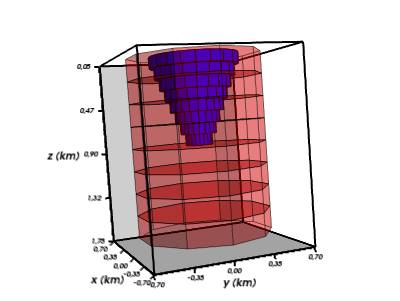

In [10]:
img(filename='figs/kimberlite_amf_td_true_initial.png')

### Observed AMF with initial estimate

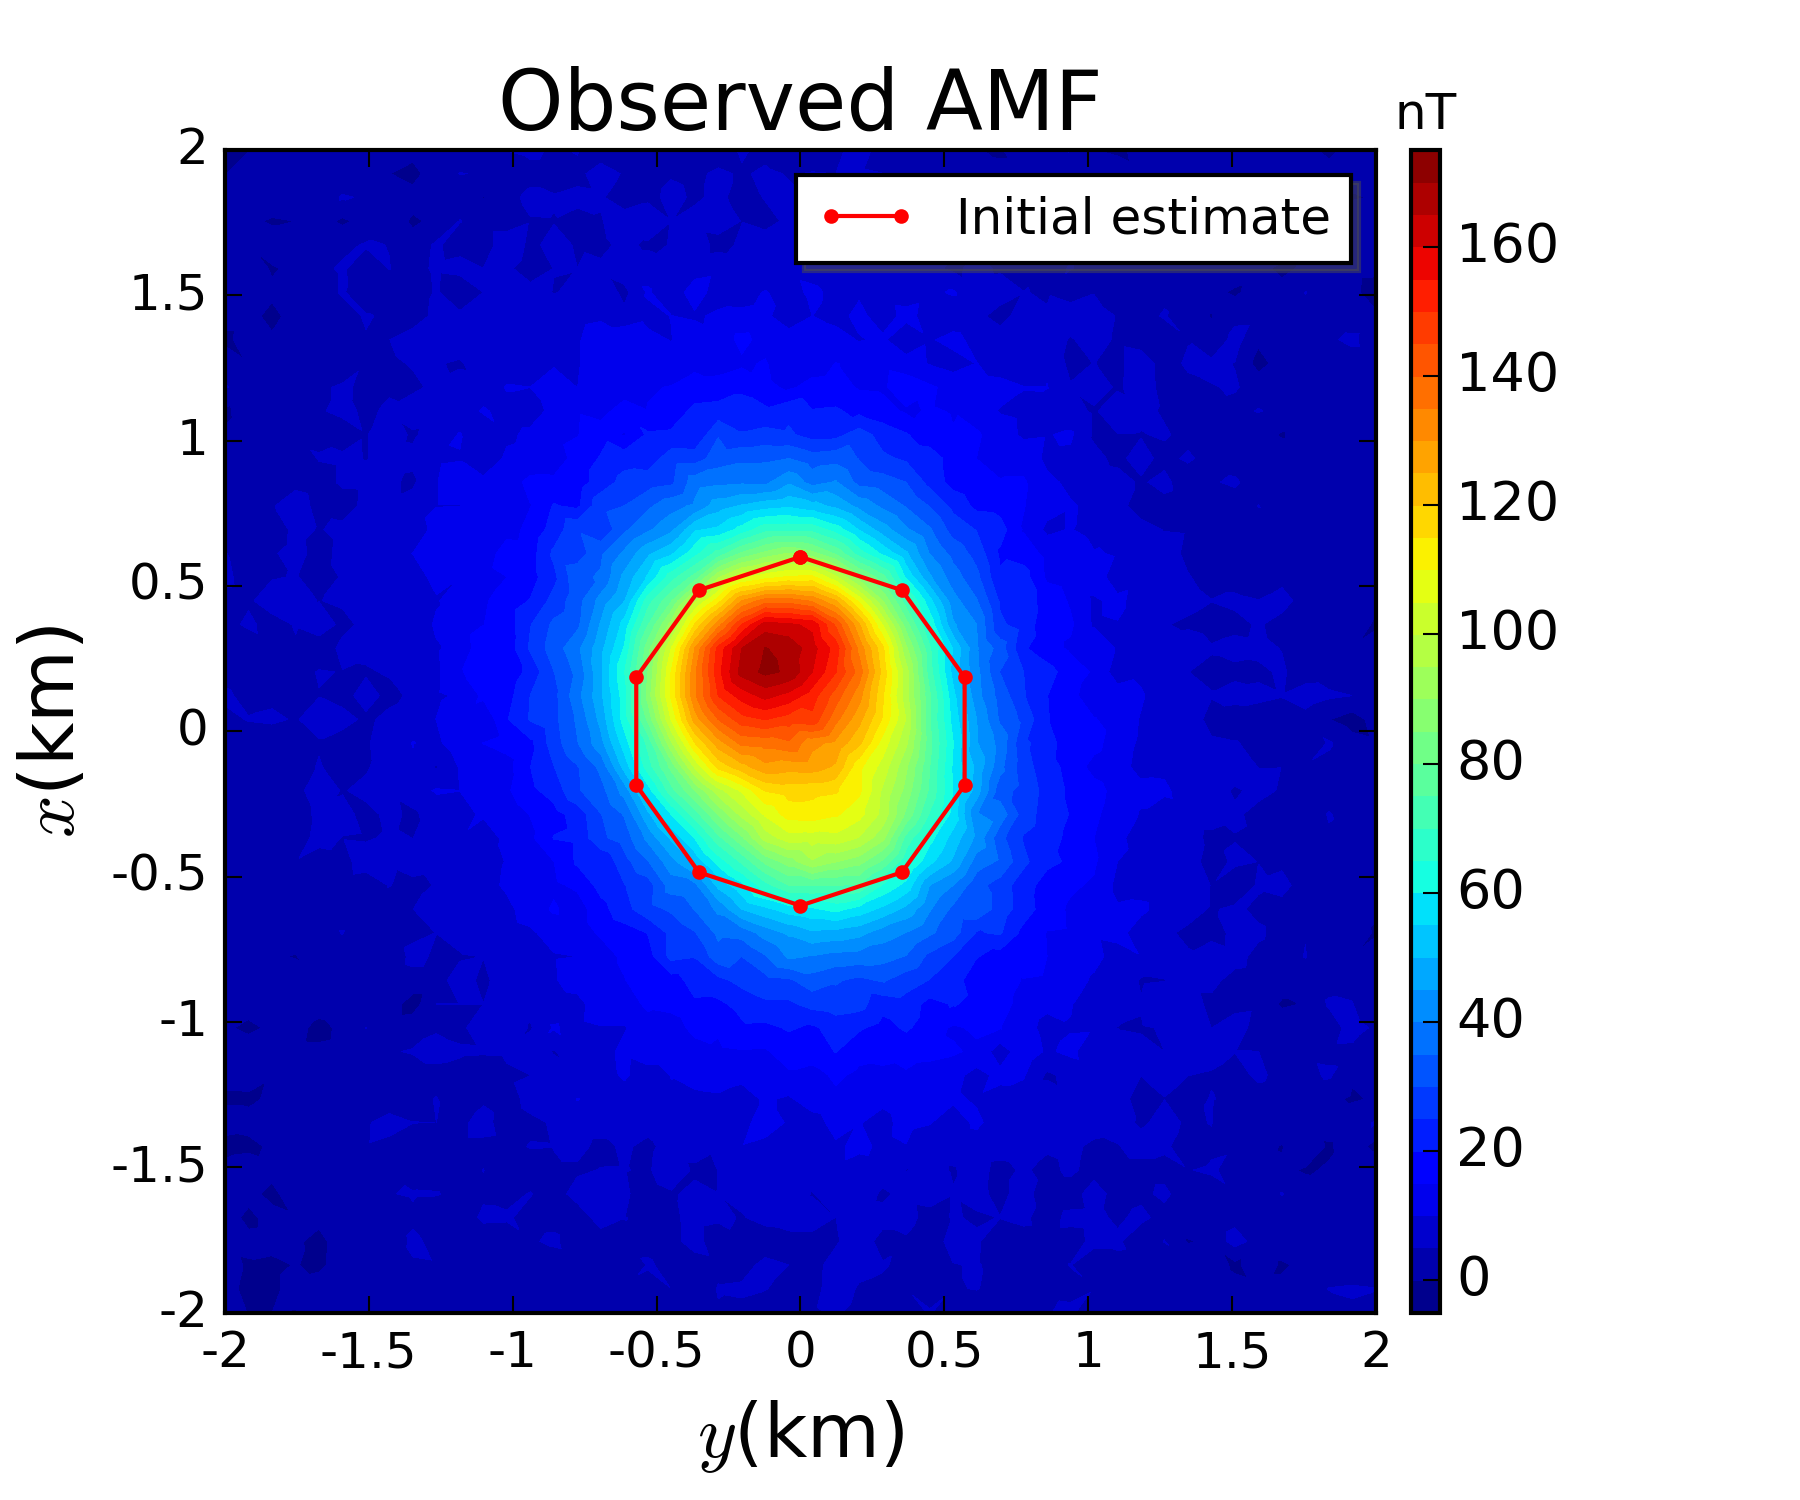

In [11]:
plt.figure(figsize=(6,5))
plt.title('Observed AMF', fontsize=20)
plt.tricontourf(yp, xp, dobs, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(kimberlite_model['prisms'][0], '.-k', xy2ne=True)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#source.set_label('Outcropping polygon')
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
#plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
#plt.savefig('figs/kimberlite_amf_obs_data_true_inital.png', dpi=300)
#plt.show()
img(filename='figs/kimberlite_amf_obs_data_true_inital.png', width=400, height=400)

### Regularization parameters

In [12]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 1000.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 0.001  # adjacent radial distances within each prism
a2 = 0.01   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 0.3     # vertically adjacent origins
a6 = 0.00001   # zero order Tikhonov on adjacent radial distances
a7 = 0.00001     # zero order Tikhonov on thickness of each prism

In [13]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

### Inversion

Here we run the inversion 10 times. The first one with the correct magnetization direction and after that we add 0.2 degrees on inclination and 0.8 degrees on declination at each iteration.

In [14]:
d_fit_list = []
m_est_list = []
model_est_list = []
phi_list_list = []

for i in range(10):
    props = {'magnetization': utils.ang2vec(
        kimberlite_model['intensity'], inc + i*0.2, dec + i*0.8)}
    d_fit, m_est, model_est, phi_list = mfun.levmarq_amf(xp, yp, zp, m0, M, L, delta, itmax,
                                                        itmax_marq, lamb, dlamb, epsilon,
                                                        mmin, mmax, m_out, dobs, props, alpha, z0, dz)
    d_fit_list.append(d_fit)
    m_est_list.append(m_est)
    model_est_list.append(model_est)
    phi_list_list.append(phi_list)

it:  0   it_marq:  0   lambda: 1e+03   misfit: 3.1932e+03
it:  1   it_marq:  0   lambda: 1e+02   misfit: 2.4107e+03
it:  2   it_marq:  0   lambda: 1e+01   misfit: 9.1568e+02
it:  3   it_marq:  0   lambda: 1e+00   misfit: 2.6941e+02
it:  4   it_marq:  0   lambda: 1e-01   misfit: 1.4705e+01
it:  5   it_marq:  0   lambda: 1e-02   misfit: 3.0512e+02
it:  5   it_marq:  1   lambda: 1e-01   misfit: 3.0862e+01
it:  5   it_marq:  2   lambda: 1e+00   misfit: 7.5030e+00
it:  6   it_marq:  0   lambda: 1e-01   misfit: 1.3246e+01
it:  6   it_marq:  1   lambda: 1e+00   misfit: 6.5029e+00
it:  7   it_marq:  0   lambda: 1e-01   misfit: 1.0891e+01
it:  7   it_marq:  1   lambda: 1e+00   misfit: 5.7626e+00
it:  8   it_marq:  0   lambda: 1e-01   misfit: 8.9145e+00
it:  8   it_marq:  1   lambda: 1e+00   misfit: 5.2231e+00
it:  9   it_marq:  0   lambda: 1e-01   misfit: 7.4437e+00
it:  9   it_marq:  1   lambda: 1e+00   misfit: 4.8300e+00
it: 10   it_marq:  0   lambda: 1e-01   misfit: 6.3719e+00
it: 10   it_ma

# Results

In [19]:
inc_list = []
dec_list = []
for i in range(10):
    inc_list.append(inc + i*0.2)
    dec_list.append(dec + i*0.8)

In [20]:
res = []
for d in d_fit_list:
    r = dobs - d
    res.append((r)) # residual

### Data fitting of all inversions

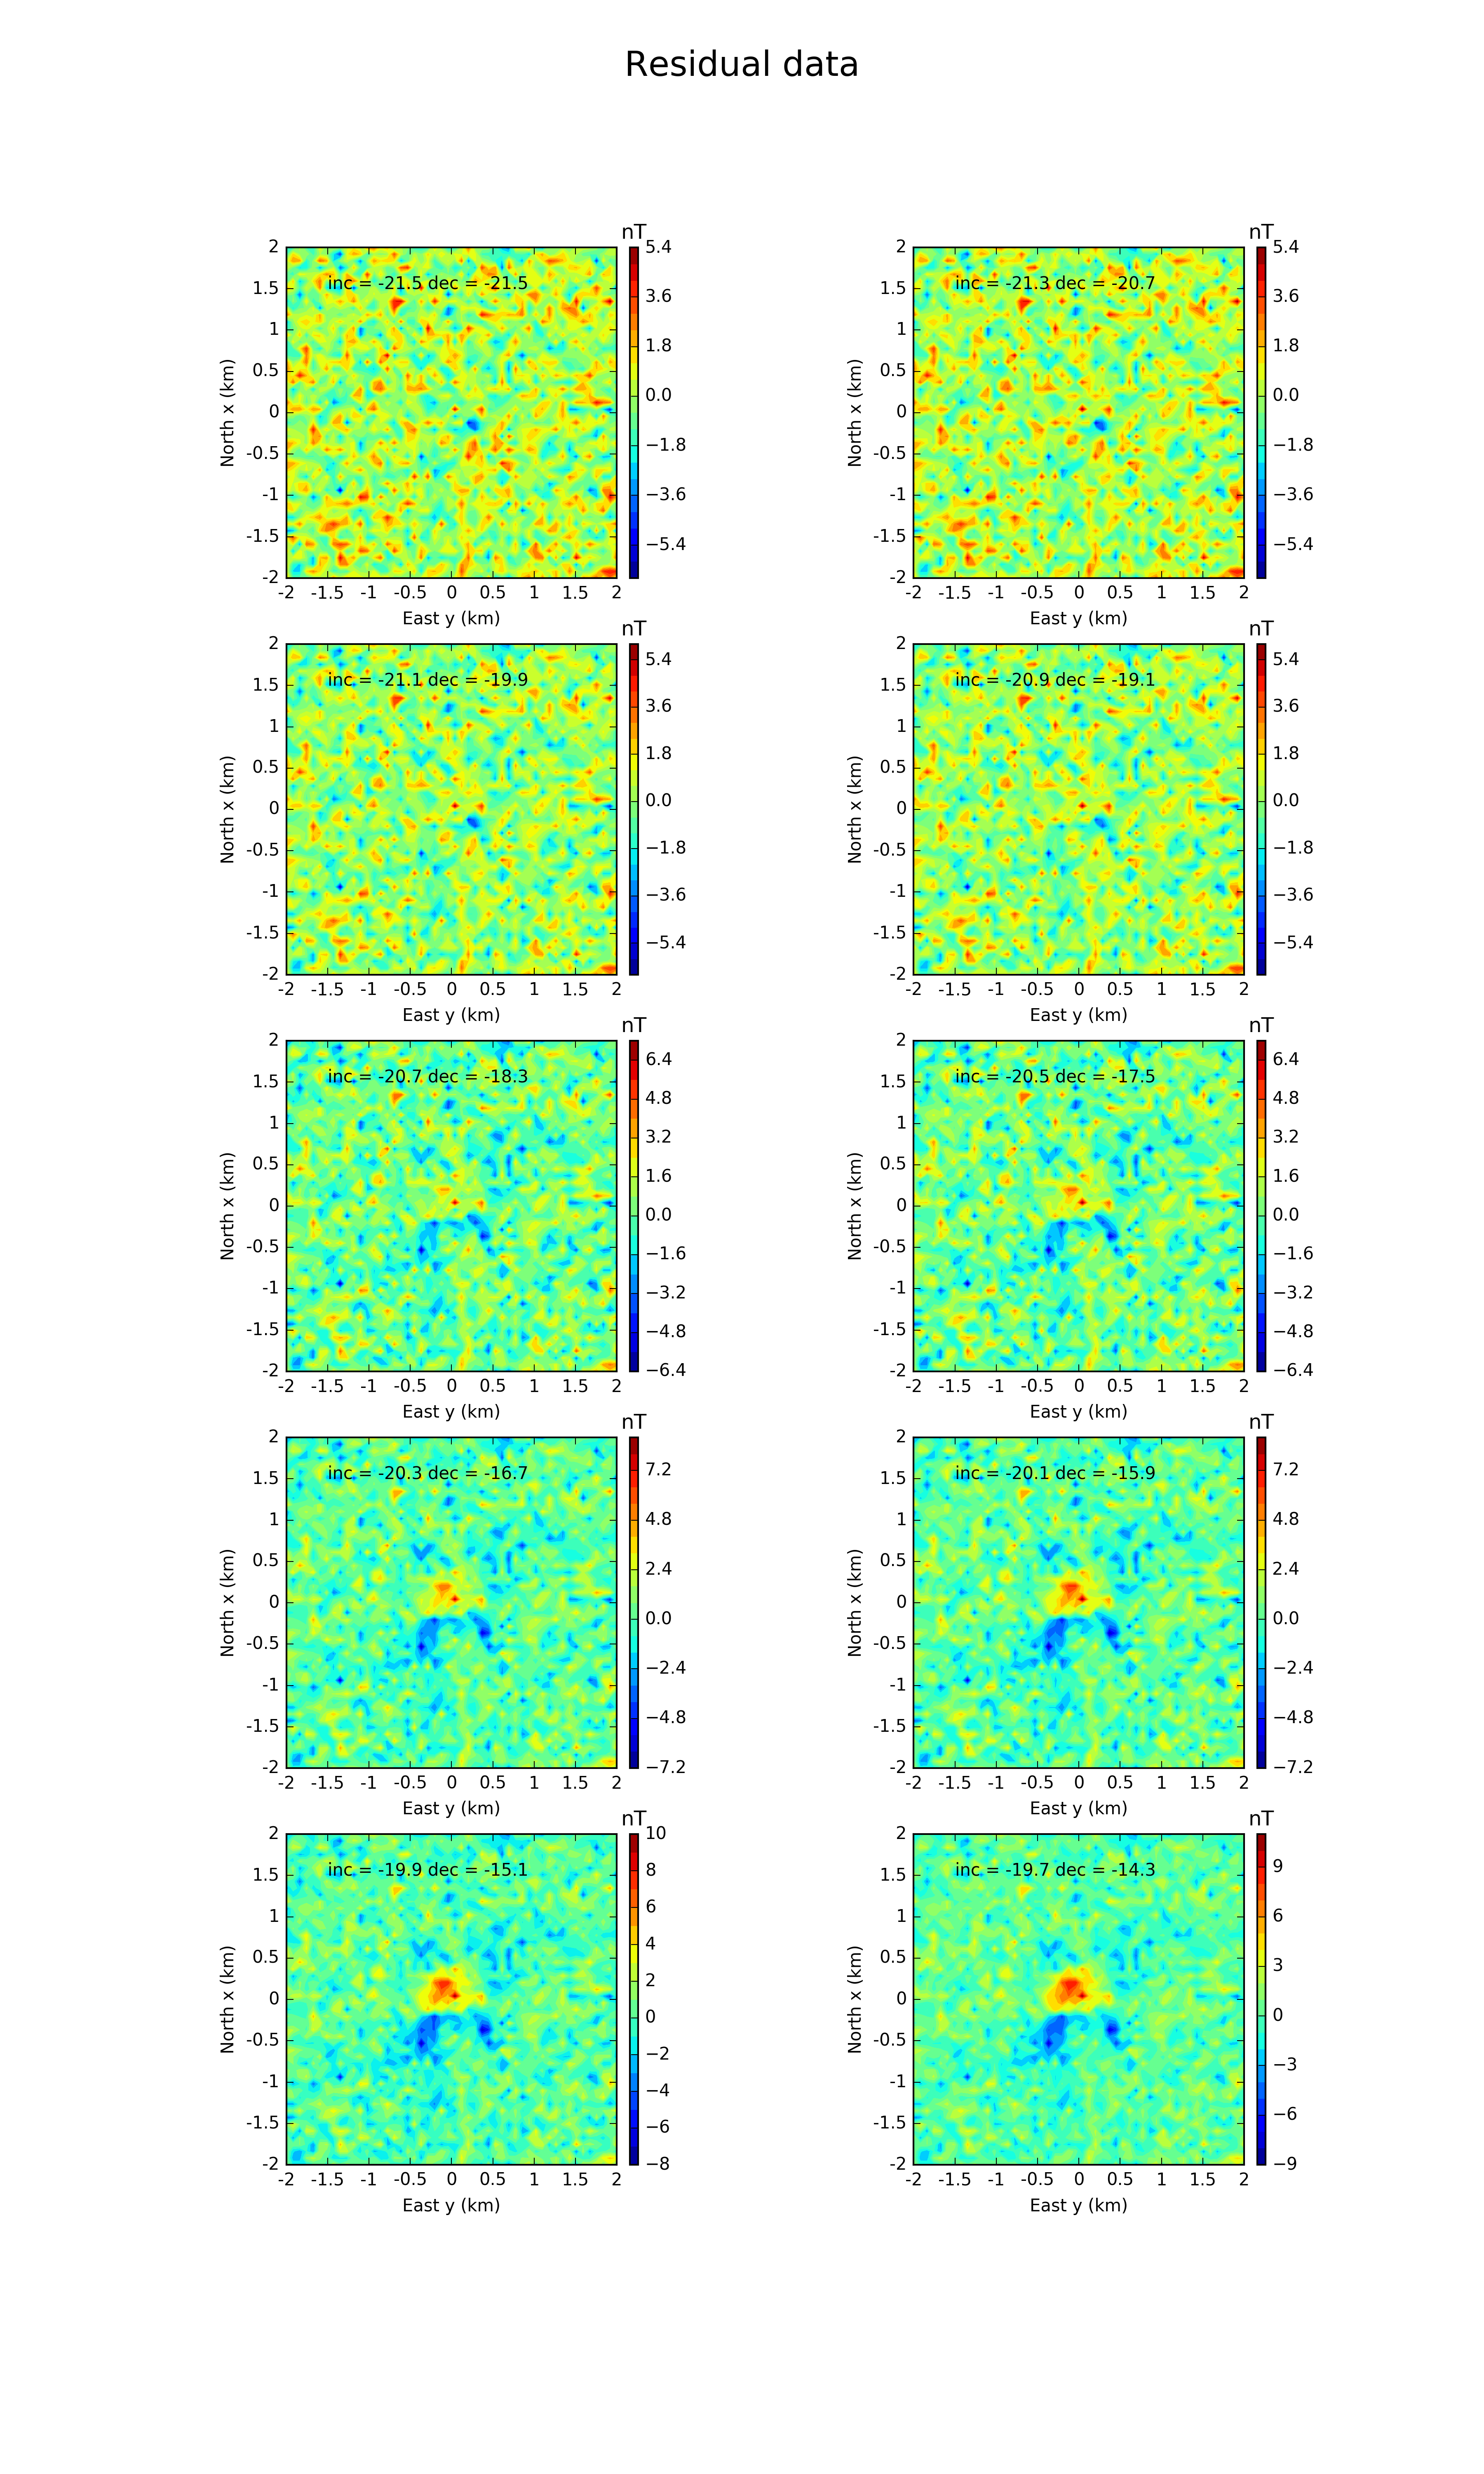

In [21]:
plt.figure(figsize=(12,20))
plt.subplot(5, 2, 1)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[0], dec_list[0]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[0], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()
plt.suptitle('Residual data', fontsize=20)

plt.subplot(5, 2, 2)
#plt.title("Residual data", fontsize = 18)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[1], dec_list[1]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[1], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()

plt.subplot(5, 2, 3)
#plt.title("Residual data", fontsize = 18)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[2], dec_list[2]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[2], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()

plt.subplot(5, 2, 4)
#plt.title("Residual data", fontsize = 18)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[3], dec_list[3]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[3], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()

plt.subplot(5, 2, 5)
#plt.title("Residual data", fontsize = 18)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[4], dec_list[4]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[4], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()

plt.subplot(5, 2, 6)
#plt.title("Residual data", fontsize = 18)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[5], dec_list[5]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[5], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()

plt.subplot(5, 2, 7)
#plt.title("Residual data", fontsize = 18)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[6], dec_list[6]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[6], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()

plt.subplot(5, 2, 8)
#plt.title("Residual data", fontsize = 18)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[7], dec_list[7]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[7], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()

plt.subplot(5, 2, 9)
#plt.title("Residual data", fontsize = 18)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[8], dec_list[8]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[8], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()

plt.subplot(5, 2, 10)
#plt.title("Residual data", fontsize = 18)
plt.text(-1500., 1500., r'inc = %s dec = %s' % (inc_list[9], dec_list[9]), fontsize=10)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res[9], regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
mpl.m2km()

plt.savefig('figs/kimberlite_amf_varying_direction_fit.png', dpi=300)
#plt.show()

img(filename='figs/kimberlite_amf_varying_direction_fit.png')

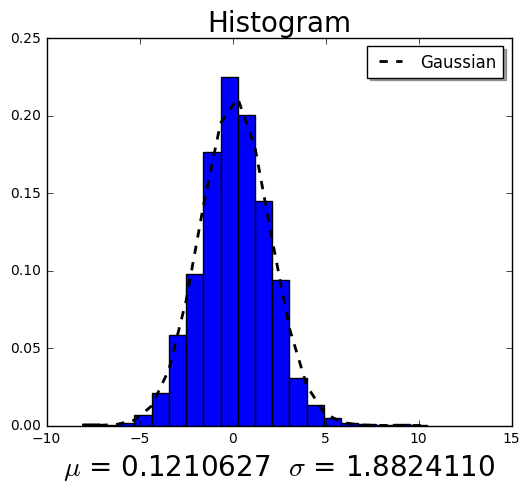

In [24]:
plt.figure(figsize=(6,5))
plt.title('Histogram', fontsize = 20)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res[-1]), np.std(res[-1])), fontsize=20)
nbins = 20
n, bins, patches = plt.hist(res[-1],bins=nbins, normed=True, color='blue')
gauss = normpdf(bins, np.mean(res[-1]), np.std(res[-1]))
plt.plot(bins, gauss, 'k--', linewidth=2., label='Gaussian')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)

plt.savefig('figs/kimberlite_amf_wrong_dec_hist.png', dpi=300)
plt.show()

### Convergence of all inversions

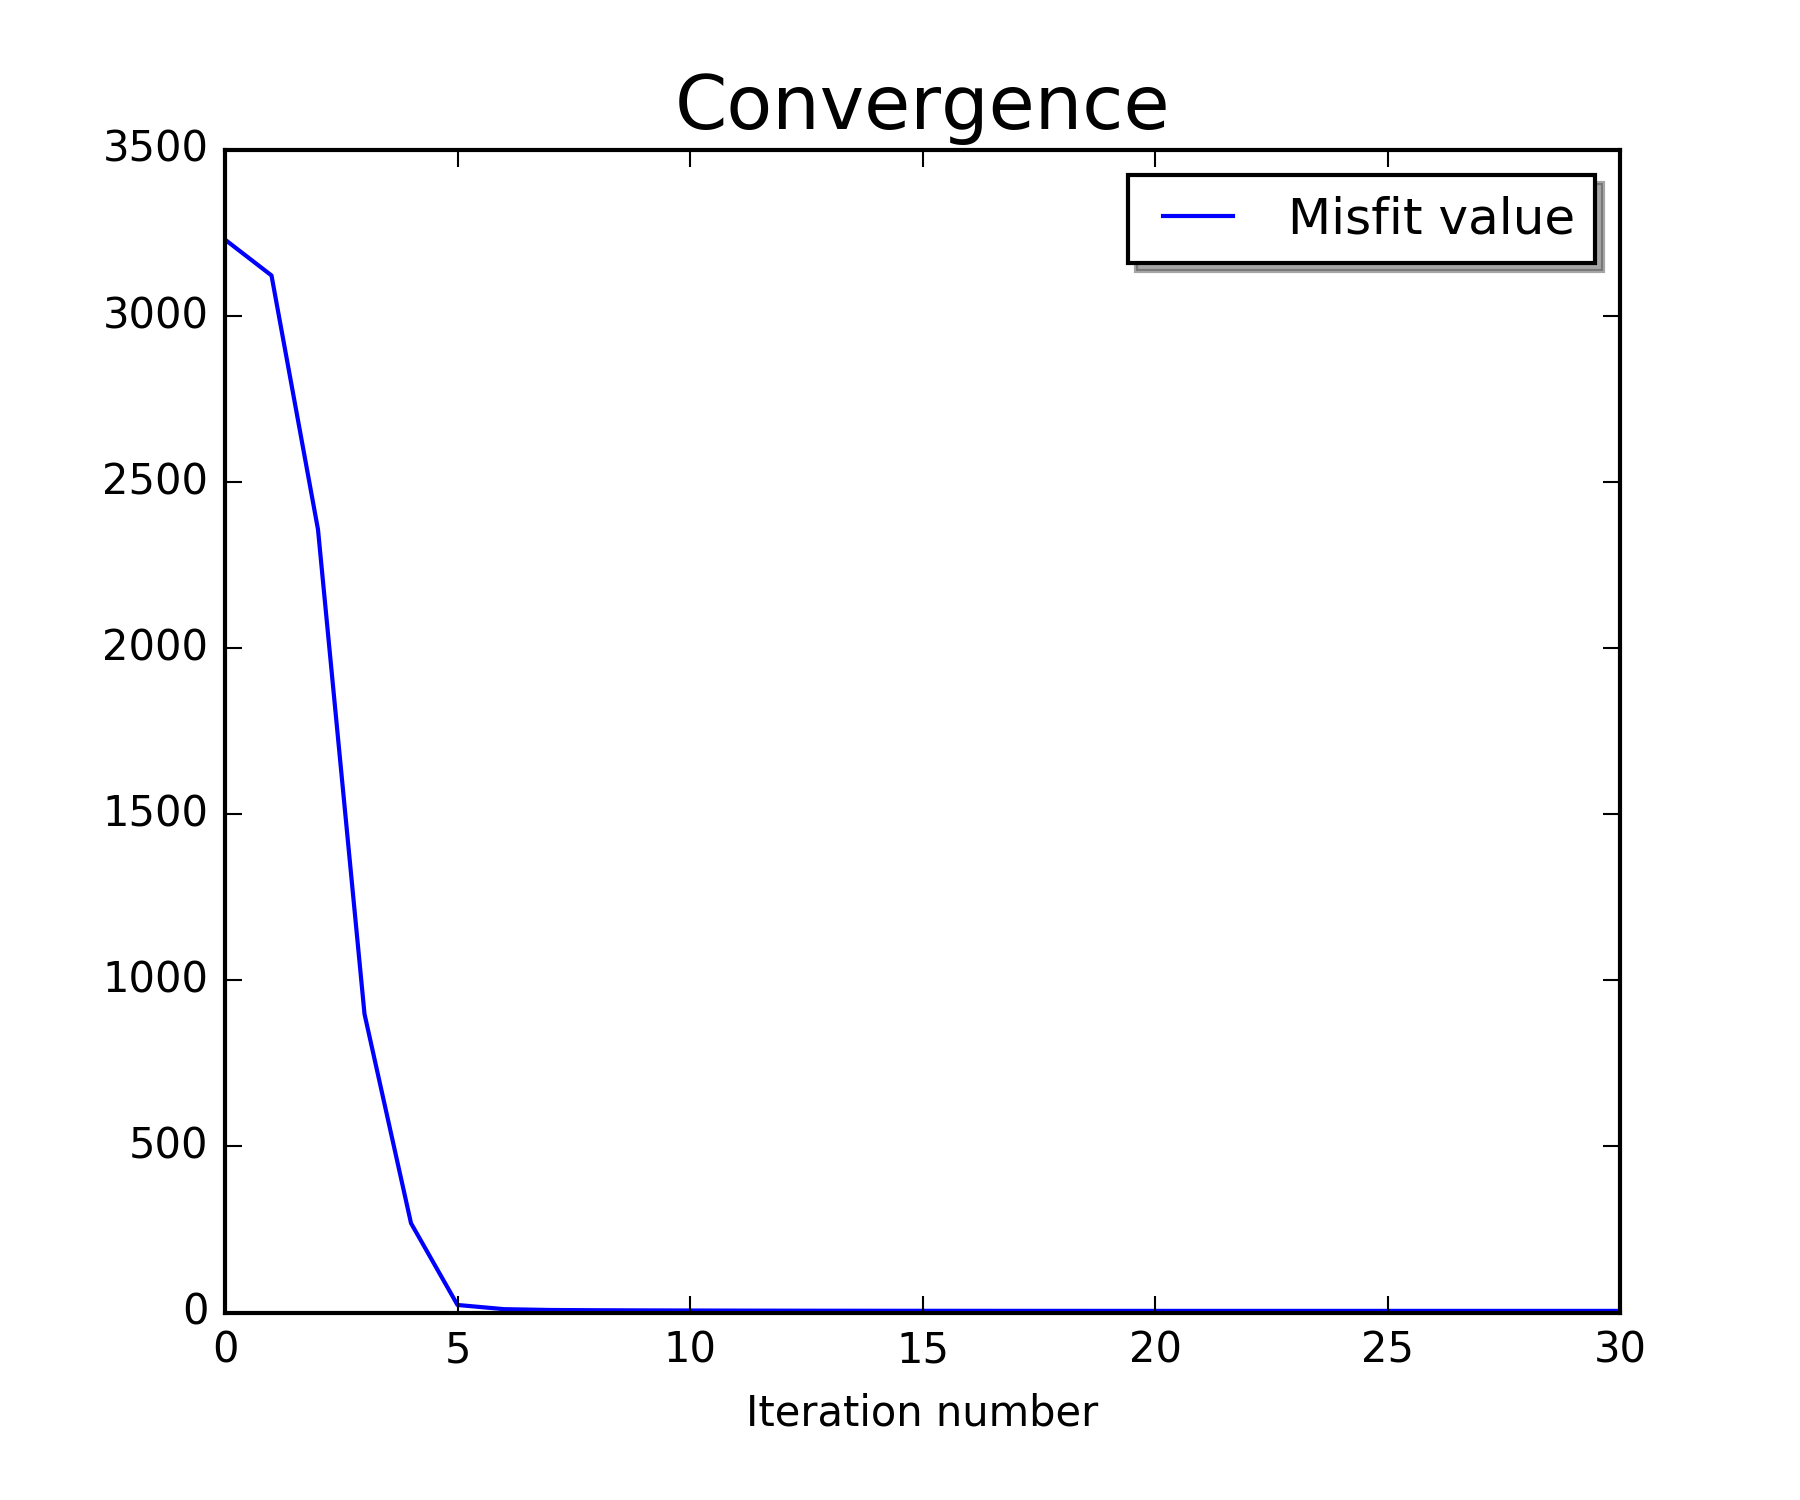

In [36]:
plt.figure(figsize=(6,5))
plt.title('Convergence', fontsize = 18)
plt.xlabel('Iteration number')
#for i, phi in enumerate(phi_list_list):
#    plt.plot(phi, label='Misfit value %d' % (i))
plt.plot(phi_list_list[-1], label='Misfit value')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)

plt.savefig('figs/kimberlite_amf_wd_convergence.png', dpi=300)
#plt.show()
img(filename='figs/kimberlite_amf_wd_convergence.png', width=400, height=400)

### Result for a litlle variation for magnetization direction

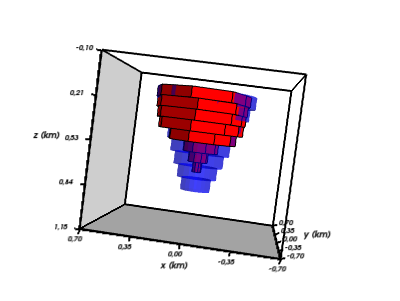

In [29]:
bounds = [-700., 700., -700., 700., -100., 1150.]

red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
white, black = (1, 1, 1), (0, 0, 0),

# Show the model
scene = myv.figure()
myv.polyprisms(kimberlite_model['prisms'], 'magnetization', color=blue, linewidth=1., opacity=.5, edges=False)
myv.polyprisms(model_est_list[-1], 'magnetization', color=red, linewidth=1.)


ax = myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.5
scene.scene.camera.position = [-312.73912567501554, -3561.7262362085721, 287.67386774078057]
scene.scene.camera.focal_point = [1.9226665366075399e-12, -2.4033331707594249e-12, 425.00000000000017]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.13341196746632145, 0.026483446094695474, -0.99070675480674641]
scene.scene.camera.clipping_range = [1993.7950353893316, 5580.9677877221075]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
#myv.title('bolacha', color=(0, 0, 0), size=1.3, height=0.5)
myv.savefig('figs/kimberlite_amf_wd_bolacha3.png')
myv.show()

img(filename='figs/kimberlite_amf_wd_bolacha3.png')

### Result for a greater variation for magnetization direction

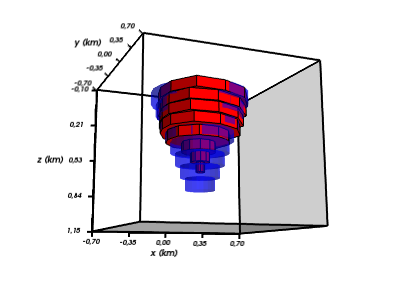

In [37]:
bounds = [-700., 700., -700., 700., -100., 1150.]

red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
white, black = (1, 1, 1), (0, 0, 0),

# Show the model
scene = myv.figure()
myv.polyprisms(kimberlite_model['prisms'], 'magnetization', color=blue, linewidth=1., opacity=.5, edges=False)
myv.polyprisms(model_est_list[-1], 'magnetization', color=red, linewidth=1.)


ax = myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.5
scene.scene.camera.position = [-1358.4495936442941, 3241.6425529534445, 1095.0196037678566]
scene.scene.camera.focal_point = [1.1115415914762344e-12, 4.8066663415188518e-13, 424.99999999999943]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [-0.069838400113651236, 0.17376780317072943, -0.98230715585848405]
scene.scene.camera.clipping_range = [1555.7568575367334, 6132.3676045661978]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
#myv.title('bolacha', color=(0, 0, 0), size=1.3, height=0.5)
myv.savefig('figs/kimberlite_amf_wd_bolacha4.png')
myv.show()

img(filename='figs/kimberlite_amf_wd_bolacha4.png')